In [1]:
import os
import numpy as np
import pandas as pd
import librosa
from six.moves import cPickle as pickle
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt

## Extract or load features

In [48]:
def extract_features(file_name):
   # extract different sound features
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        #mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        #mfccsscaled = np.mean(mfccs,axis=1)
        #mfccsscaled = mfccsscaled.T
        mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40).T,axis=0)#40
        chroma_stft = np.mean(librosa.feature.chroma_stft(y=audio, sr=sample_rate).T,axis=0)#12
        rmse = np.mean(librosa.feature.rms(y=audio),axis=1)#1
        #spec_cent = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sample_rate),axis=1)#1
        #spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sample_rate).T,axis=0)#1
        #rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sample_rate).T,axis=0)#1
        #zcr = np.sum(librosa.feature.zero_crossing_rate(audio).T,axis=0)#1
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
    ft=np.hstack([mfccs,chroma_stft,rmse]) 
    return ft

In [3]:
# Set the path to the full UrbanSound dataset 
fulldatasetpath = 'UrbanSound8K/audio/'
metadata = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')
features = []

# Iterate through each sound file and extract the features 
for index, row in metadata.iterrows():
    file_name = os.path.join(os.path.abspath(fulldatasetpath),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    class_label = row["class"]
    data = extract_features(file_name)
    features.append([data, class_label])
    
# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])
pickle.dump(featuresdf, open('featuresdf53.p','wb'))
print('Finished feature extraction from ', len(featuresdf), ' files')

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


Finished feature extraction from  8732  files


In [2]:
# if feature is already extracted and saved, just load it
featuresdf = pickle.load(open('featuresdf53.p', 'rb'))

## Prepare training set, test set and labels

In [3]:
# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

Using TensorFlow backend.


In [4]:
# split the dataset 
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

In [5]:
np.mean(x_train[6])

0.4738442

## MLP

In [6]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()

model.add(Dense(256, input_shape=(53,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [8]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               13824     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
__________

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 6985 samples, validate on 1747 samples
Epoch 1/100
6985/6985 [==============================] - 4s 511us/step - loss: 11.8221 - acc: 0.2029 - val_loss: 7.9664 - val_acc: 0.3646

Epoch 00001: val_loss improved from inf to 7.96639, saving model to weights.best.basic_mlp.hdf5
Epoch 2/100
6985/6985 [==============================] - 2s 251us/step - loss: 8.1680 - acc: 0.3034 - val_loss: 1.8853 - val_acc: 0.4808

Epoch 00002: val_loss improved from 7.96639 to 1.88533, saving model to weights.best.basic_mlp.hdf5
Epoch 3/100
6985/6985 [==============================] - 2s 266us/step - loss: 2.4222 - acc: 0.3364 - val_loss: 1.7675 - val_acc: 0.4694

Epoch 00003: val_loss improved from 1.88533 to 1.76752, saving model to weights.best.basic_mlp.hdf5
Epoch 4/100
6985/6985 [==============================] - 2s 304us/step - loss: 1.8339 - acc: 0.3953 - val_loss: 1.5576 - val_acc: 0.5318

Epoch 0


Epoch 00033: val_loss did not improve from 0.53799
Epoch 34/100
6985/6985 [==============================] - 2s 221us/step - loss: 0.6964 - acc: 0.7599 - val_loss: 0.5294 - val_acc: 0.8294

Epoch 00034: val_loss improved from 0.53799 to 0.52945, saving model to weights.best.basic_mlp.hdf5
Epoch 35/100
6985/6985 [==============================] - 2s 222us/step - loss: 0.6850 - acc: 0.7664 - val_loss: 0.5128 - val_acc: 0.8414

Epoch 00035: val_loss improved from 0.52945 to 0.51276, saving model to weights.best.basic_mlp.hdf5
Epoch 36/100
6985/6985 [==============================] - 2s 221us/step - loss: 0.6780 - acc: 0.7603 - val_loss: 0.5025 - val_acc: 0.8466

Epoch 00036: val_loss improved from 0.51276 to 0.50247, saving model to weights.best.basic_mlp.hdf5
Epoch 37/100
6985/6985 [==============================] - 2s 224us/step - loss: 0.6636 - acc: 0.7712 - val_loss: 0.5187 - val_acc: 0.8323

Epoch 00037: val_loss did not improve from 0.50247
Epoch 38/100
6985/6985 [=================


Epoch 00073: val_loss did not improve from 0.38267
Epoch 74/100
6985/6985 [==============================] - 3s 368us/step - loss: 0.5219 - acc: 0.8218 - val_loss: 0.3939 - val_acc: 0.8838

Epoch 00074: val_loss did not improve from 0.38267
Epoch 75/100
6985/6985 [==============================] - 2s 272us/step - loss: 0.5204 - acc: 0.8259 - val_loss: 0.4052 - val_acc: 0.8867

Epoch 00075: val_loss did not improve from 0.38267
Epoch 76/100
6985/6985 [==============================] - 2s 234us/step - loss: 0.5150 - acc: 0.8249 - val_loss: 0.3944 - val_acc: 0.8758

Epoch 00076: val_loss did not improve from 0.38267
Epoch 77/100
6985/6985 [==============================] - 2s 232us/step - loss: 0.5234 - acc: 0.8206 - val_loss: 0.3916 - val_acc: 0.8878

Epoch 00077: val_loss did not improve from 0.38267
Epoch 78/100
6985/6985 [==============================] - 2s 236us/step - loss: 0.5380 - acc: 0.8179 - val_loss: 0.3858 - val_acc: 0.8901

Epoch 00078: val_loss did not improve from 0.3826

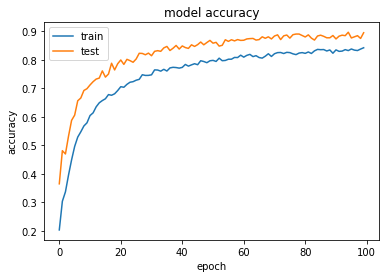

Training completed in time:  0:04:02.033665


In [9]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='weights.best.basic_mlp.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

duration = datetime.now() - start
print("Training completed in time: ", duration)

In [10]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9408732999284181
Testing Accuracy:  0.8946765882667297


In [11]:
y_pred = model.predict(x_test)

In [35]:
def confusion(ground_truth, pred):
    """
    Calculate a confusion matrix for a prediction
    Args:
        ground_truth : the true label of test data, one hot coded
        pred : a prediction, one hot coded
    Returns:
        The confusion matrix
    """
    m = np.zeros((10, 10))
    for i in range(ground_truth.shape[0]):
        label = np.argmax(ground_truth[i][:])
        my_pred = np.argmax(pred[i][:])
        m[label][my_pred] += 1
    # add normalization
    # print(m)
    row_sum = np.sum(m, axis = 1)
    # print(row_sum)
    m = m / row_sum[..., None]
    return m

In [36]:
# plot confusion metrix
matrix = confusion(y_test, y_pred)
print(matrix)

[[190.   0.   3.   2.   0.   4.   0.   1.   1.   2.]
 [  1.  75.   1.   1.   1.   1.   0.   1.   0.   5.]
 [  6.   0. 154.   9.   1.   1.   3.   1.   1.   7.]
 [  2.   2.  12. 178.   0.   1.   3.   0.   2.   1.]
 [  0.   0.   7.   4. 180.   0.   2.   7.   0.   6.]
 [  2.   0.   5.   0.   0. 186.   0.   0.   0.   0.]
 [  0.   0.   3.   4.   0.   0.  64.   0.   0.   1.]
 [  3.   0.   0.   0.   3.   0.   2. 200.   0.   0.]
 [  0.   0.   5.   5.   0.   0.   0.   0. 155.   0.]
 [  9.   0.  27.   6.   0.   2.   0.   3.   2. 181.]]
[203.  86. 183. 201. 206. 193.  72. 208. 165. 230.]
[[0.93596059 0.         0.01477833 0.00985222 0.         0.01970443
  0.         0.00492611 0.00492611 0.00985222]
 [0.01162791 0.87209302 0.01162791 0.01162791 0.01162791 0.01162791
  0.         0.01162791 0.         0.05813953]
 [0.03278689 0.         0.84153005 0.04918033 0.00546448 0.00546448
  0.01639344 0.00546448 0.00546448 0.03825137]
 [0.00995025 0.00995025 0.05970149 0.88557214 0.         0.00497512
  0.

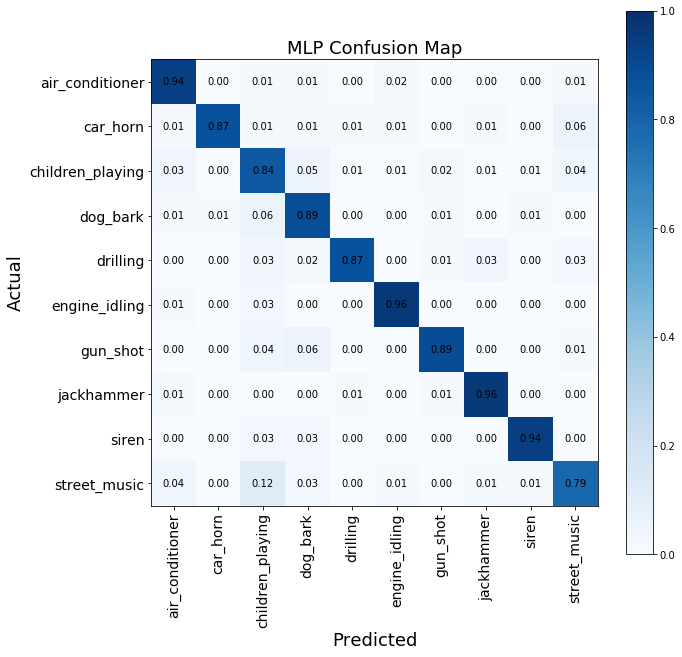

In [37]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=[10,10])
for i in range(10):
    for j in range(10):
        plt.text(j, i, "{0:.2f}".format(matrix[i][j]),  ha='center', va='center', color='black')
plt.imshow(matrix, cmap = plt.cm.Blues, interpolation='none', vmin=0, vmax=1)
# plt.imshow(matrix, cmap = plt.cm.Blues, interpolation='none')
# plot_confusion_matrix(matrix, classes=le.classes_, title='Normalized confusion matrix')
plt.colorbar()
plt.title('MLP Confusion Map', fontsize=18)
plt.ylabel('Actual', fontsize=18)
plt.xlabel('Predicted', fontsize=18)
plt.grid(b=False)
plt.yticks(range(10), le.classes_, fontsize=14)
plt.xticks(range(10), le.classes_, fontsize=14, rotation='vertical')
plt.show()

In [15]:
# plot overall ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold= roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc = auc(fpr, tpr)

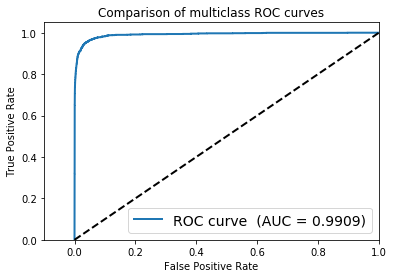

In [16]:
plt.plot(fpr, tpr,
         label='ROC curve '+ ' (AUC = {0:0.4f})'
               ''.format(roc_auc), linestyle='-', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Overall ROC curves')
plt.legend(loc="lower right", fontsize=14)
plt.show()

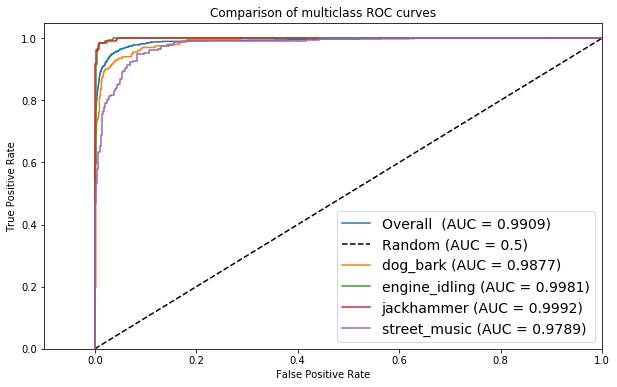

In [29]:
# plot ROC curve for each class 
plt.figure(figsize=[10,6])
# plot overall curve
fpr, tpr, threshold= roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr,
         label='Overall '+ ' (AUC = {0:0.4f})'
               ''.format(roc_auc))
#plot random curve
plt.plot([0, 1], [0, 1], 'k--', label = 'Random (AUC = 0.5)')

#choose some classes to plot
for idx in [3 ,5, 7, 9]:
    fpr, tpr, threshold= roc_curve(y_test[:, idx], y_pred[:, idx])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,
         label=str(le.classes_[idx])+ ' (AUC = {0:0.4f})'
               ''.format(roc_auc))
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of multiclass ROC curves')
plt.legend(loc="lower right", fontsize=14)
plt.show()

## Extract features for CNN

In [31]:
max_pad_len = 174
def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        chroma_stft = librosa.feature.chroma_stft(y=audio, sr=sample_rate)#12
        rmse = librosa.feature.rms(y=audio)#1
        ft=np.vstack([mfccs,chroma_stft,rmse]) 
        pad_width = max_pad_len - ft.shape[1]
        ft = np.pad(ft, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
    #print(ft.shape)
    return ft

In [ ]:
max_pad_len = 174

def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

In [ ]:
def extract_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        #mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        #mfccsscaled = np.mean(mfccs,axis=1)
        #mfccsscaled = mfccsscaled.T
        mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=20).T,axis=0)#40
        chroma_stft = np.mean(librosa.feature.chroma_stft(y=audio, sr=sample_rate).T,axis=0)#12
        rmse = np.mean(librosa.feature.rms(y=audio),axis=1)#1
        #spec_cent = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sample_rate),axis=1)#1
        #spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sample_rate).T,axis=0)#1
        #rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sample_rate).T,axis=0)#1
        #zcr = np.sum(librosa.feature.zero_crossing_rate(audio).T,axis=0)#1
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
    ft=np.hstack([mfccs,chroma_stft,rmse]) 
    return ft

In [29]:
data = extract_features('UrbanSound8K/audio/fold1/101415-3-0-2.wav')
data1 = extract_features('UrbanSound8K/audio/fold2/100652-3-0-0.wav')
data2 = extract_features('UrbanSound8K/audio/fold3/102105-3-0-0.wav')
data3 = extract_features('UrbanSound8K/audio/fold4/102102-3-0-0.wav')

(53, 174)
(53, 174)
(53, 174)
(53, 174)


In [32]:
# Load various imports 
import pandas as pd
import os
import librosa

# Set the path to the full UrbanSound dataset 
fulldatasetpath = 'UrbanSound8K/audio/'

metadata = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')

features = []

# Iterate through each sound file and extract the features 
for index, row in metadata.iterrows():
    
    file_name = os.path.join(os.path.abspath(fulldatasetpath),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    
    class_label = row["class"]
    data = extract_features(file_name)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])
pickle.dump(featuresdf, open('featuresdfcnn53.p','wb'))

print('Finished feature extraction from ', len(featuresdf), ' files')

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


Finished feature extraction from  8732  files


In [38]:
featuresdf = pickle.load(open('featuresdfcnn53.p', 'rb'))

## CNN Model

In [39]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

In [40]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_rows = 53
num_columns = 174
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))

In [41]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [42]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 52, 173, 16)       80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 86, 16)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 26, 86, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 85, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 42, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 42, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 41, 64)        8256      
__________

Train on 6985 samples, validate on 1747 samples
Epoch 1/100
6985/6985 [==============================] - 17s 2ms/step - loss: 3.5519 - acc: 0.1727 - val_loss: 2.1252 - val_acc: 0.2421

Epoch 00001: val_loss improved from inf to 2.12524, saving model to weights.best.basic_cnn.hdf5
Epoch 2/100
6985/6985 [==============================] - 16s 2ms/step - loss: 1.8870 - acc: 0.3204 - val_loss: 1.9298 - val_acc: 0.3417

Epoch 00002: val_loss improved from 2.12524 to 1.92980, saving model to weights.best.basic_cnn.hdf5
Epoch 3/100
6985/6985 [==============================] - 16s 2ms/step - loss: 1.6264 - acc: 0.4162 - val_loss: 1.6777 - val_acc: 0.4053

Epoch 00003: val_loss improved from 1.92980 to 1.67773, saving model to weights.best.basic_cnn.hdf5
Epoch 4/100
6985/6985 [==============================] - 16s 2ms/step - loss: 1.4331 - acc: 0.4800 - val_loss: 1.4973 - val_acc: 0.4871

Epoch 00004: val_loss improved from 1.67773 to 1.49734, saving model to weights.best.basic_cnn.hdf5
Epoch 5/

6985/6985 [==============================] - 16s 2ms/step - loss: 0.4533 - acc: 0.8467 - val_loss: 0.5692 - val_acc: 0.8260

Epoch 00037: val_loss did not improve from 0.49917
Epoch 38/100
6985/6985 [==============================] - 18s 3ms/step - loss: 0.4686 - acc: 0.8407 - val_loss: 0.5067 - val_acc: 0.8529

Epoch 00038: val_loss did not improve from 0.49917
Epoch 39/100
6985/6985 [==============================] - 15s 2ms/step - loss: 0.4442 - acc: 0.8498 - val_loss: 0.4815 - val_acc: 0.8638

Epoch 00039: val_loss improved from 0.49917 to 0.48152, saving model to weights.best.basic_cnn.hdf5
Epoch 40/100
6985/6985 [==============================] - 18s 3ms/step - loss: 0.4289 - acc: 0.8550 - val_loss: 0.5145 - val_acc: 0.8472

Epoch 00040: val_loss did not improve from 0.48152
Epoch 41/100
6985/6985 [==============================] - 20s 3ms/step - loss: 0.4247 - acc: 0.8590 - val_loss: 0.4927 - val_acc: 0.8512

Epoch 00041: val_loss did not improve from 0.48152
Epoch 42/100
6985/6

6985/6985 [==============================] - 14s 2ms/step - loss: 0.2295 - acc: 0.9227 - val_loss: 0.3370 - val_acc: 0.9056

Epoch 00077: val_loss did not improve from 0.31691
Epoch 78/100
6985/6985 [==============================] - 14s 2ms/step - loss: 0.2345 - acc: 0.9190 - val_loss: 0.3584 - val_acc: 0.8941

Epoch 00078: val_loss did not improve from 0.31691
Epoch 79/100
6985/6985 [==============================] - 14s 2ms/step - loss: 0.2378 - acc: 0.9185 - val_loss: 0.3217 - val_acc: 0.9050

Epoch 00079: val_loss did not improve from 0.31691
Epoch 80/100
6985/6985 [==============================] - 14s 2ms/step - loss: 0.2155 - acc: 0.9266 - val_loss: 0.3232 - val_acc: 0.9067

Epoch 00080: val_loss did not improve from 0.31691
Epoch 81/100
6985/6985 [==============================] - 17s 2ms/step - loss: 0.2284 - acc: 0.9185 - val_loss: 0.3288 - val_acc: 0.9044

Epoch 00081: val_loss did not improve from 0.31691
Epoch 82/100
6985/6985 [==============================] - 14s 2ms/st

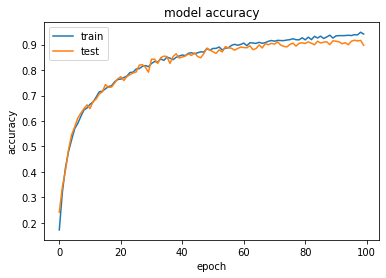

Training completed in time:  0:25:53.069602


In [43]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 
import matplotlib.pyplot as plt
#num_epochs = 12
#num_batch_size = 128

#num_epochs = 72
num_epochs = 100
num_batch_size = 256

checkpointer = ModelCheckpoint(filepath='weights.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history=model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

duration = datetime.now() - start
print("Training completed in time: ", duration)

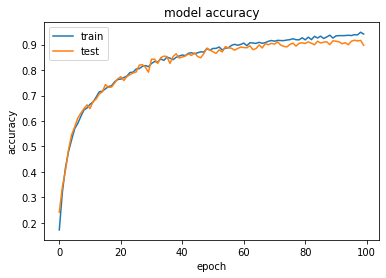

In [44]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [45]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9504652827487473
Testing Accuracy:  0.8969662276485271


In [38]:
y_pred = model.predict(x_test)

In [46]:
# plot confusion metrix
matrix = confusion(y_test, y_pred)
print(matrix)

[[190.   0.   3.   2.   0.   4.   0.   1.   1.   2.]
 [  1.  75.   1.   1.   1.   1.   0.   1.   0.   5.]
 [  6.   0. 154.   9.   1.   1.   3.   1.   1.   7.]
 [  2.   2.  12. 178.   0.   1.   3.   0.   2.   1.]
 [  0.   0.   7.   4. 180.   0.   2.   7.   0.   6.]
 [  2.   0.   5.   0.   0. 186.   0.   0.   0.   0.]
 [  0.   0.   3.   4.   0.   0.  64.   0.   0.   1.]
 [  3.   0.   0.   0.   3.   0.   2. 200.   0.   0.]
 [  0.   0.   5.   5.   0.   0.   0.   0. 155.   0.]
 [  9.   0.  27.   6.   0.   2.   0.   3.   2. 181.]]
[203.  86. 183. 201. 206. 193.  72. 208. 165. 230.]
[[0.93596059 0.         0.01477833 0.00985222 0.         0.01970443
  0.         0.00492611 0.00492611 0.00985222]
 [0.01162791 0.87209302 0.01162791 0.01162791 0.01162791 0.01162791
  0.         0.01162791 0.         0.05813953]
 [0.03278689 0.         0.84153005 0.04918033 0.00546448 0.00546448
  0.01639344 0.00546448 0.00546448 0.03825137]
 [0.00995025 0.00995025 0.05970149 0.88557214 0.         0.00497512
  0.

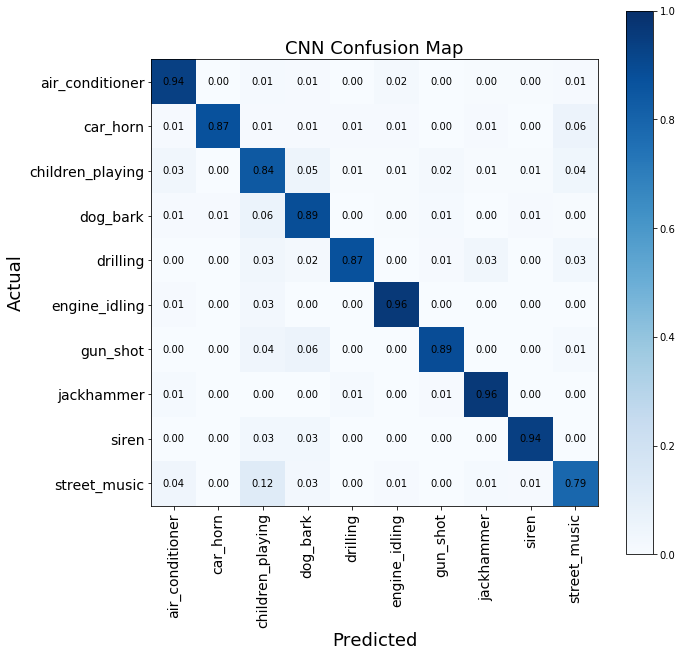

In [47]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=[10,10])
for i in range(10):
    for j in range(10):
        plt.text(j, i, "{0:.2f}".format(matrix[i][j]),  ha='center', va='center', color='black')
plt.imshow(matrix, cmap = plt.cm.Blues, interpolation='none', vmin=0, vmax=1)
# plot_confusion_matrix(matrix, classes=le.classes_, title='Normalized confusion matrix')
plt.colorbar()
plt.title('CNN Confusion Map', fontsize=18)
plt.ylabel('Actual', fontsize=18)
plt.xlabel('Predicted', fontsize=18)
plt.grid(b=False)
plt.yticks(range(10), le.classes_, fontsize=14)
plt.xticks(range(10), le.classes_, fontsize=14, rotation='vertical')
plt.show()

In [42]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold= roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc = auc(fpr, tpr)

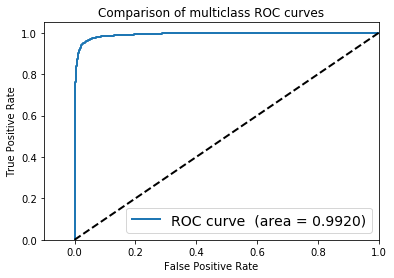

In [43]:
plt.plot(fpr, tpr,
         label='ROC curve '+ ' (area = {0:0.4f})'
               ''.format(roc_auc), linestyle='-', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Overall ROC curves')
plt.legend(loc="lower right", fontsize=14)
plt.show()

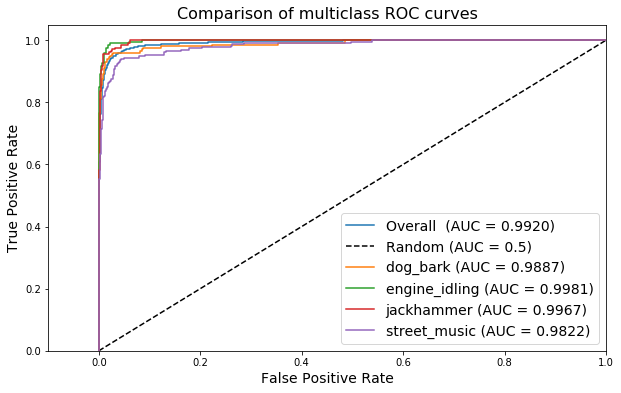

In [46]:
plt.figure(figsize=[10,6])
# plot overall curve
fpr, tpr, threshold= roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr,
         label='Overall '+ ' (AUC = {0:0.4f})'
               ''.format(roc_auc))
#plot random curve
plt.plot([0, 1], [0, 1], 'k--', label = 'Random (AUC = 0.5)')

#choose some classes to plot
for idx in [3 ,5, 7, 9]:
    fpr, tpr, threshold= roc_curve(y_test[:, idx], y_pred[:, idx])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,
         label=str(le.classes_[idx])+ ' (AUC = {0:0.4f})'
               ''.format(roc_auc))
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Comparison of multiclass ROC curves', fontsize=16)
plt.legend(loc="lower right", fontsize=14)
plt.show()